In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


from scipy.signal import medfilt
from scipy.optimize import curve_fit

In [2]:
def loadData(file_name, start = 100, until = 13100):
    data = np.genfromtxt(file_name, delimiter=",", skip_header = 1)
    ch1 = data[start:until, :2]
    ch2 = data[start:until, 2:4]
    ch3 = data[start:until, 4:6]
    ch1[:, 0] *= 1 / 3600 # horas
    ch2[:, 0] *= 1 / 3600
    ch3[:, 0] *= 1 / 3600
    ch1[:, 1] *= 1000 # mV
    ch2[:, 1] *= 1000
    ch3[:, 1] *= 1000
    return ch1, ch2, ch3

def medianFilter(data, kernel = 1001):
    array = np.zeros((len(data), 2))
    array[:, 0] = data[:, 0] / 3600 # horas
    array[:, 1] = medfilt(data[:, 1], kernel_size = kernel)
    return data

def findZeros(ch1, ch2, ch3):
    y = np.zeros((len(ch1), 3))
    y[:, 0] = ch1[:, 1]
    y[:, 1] = ch2[:, 1]
    y[:, 2] = ch3[:, 1]
    
    y = np.mean(y, axis = 1)
    dy = abs(np.diff(y))
    abs_dy = np.zeros(len(dy) + 1)
    abs_dy[0] = dy[1]
    abs_dy[1:] = dy
    
    
    dy = medfilt(abs_dy, kernel_size = 507)
    pos = (dy > 5e-2)
    dy[pos] = 0.5
    dy[np.logical_not(pos)] = 0
    return abs_dy, dy

def regression(x, y):
    def linear(x, m, b):
        return m*x + b
    
    (m, b), pcov = curve_fit(linear, x, y)
    dm = "%.0e"%pcov[0, 0]**0.5
    db = "%.0e"%pcov[1, 1]**0.5
    
    me = int(dm.split('e')[1])
    be = int(db.split('e')[1])
    
    m = round(m, -me)
    b = round(b, -be)
    dm = float(dm)
    db = float(db)
    return (m, dm), (b, db)

def getTemperature(y, m, b):
    return (y - b) / m

In [3]:
ch1, ch2, ch3 = loadData("TemperatureCalibration.csv")

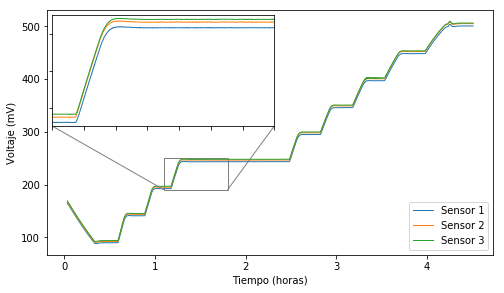

In [4]:
fig, ax = plt.subplots(figsize = (8, 4.5))

axins = zoomed_inset_axes(ax, 3.5, loc=2) # zoom-factor: 2.5, location: upper-left

for i in range(1, 4):
    ch = eval("ch%d"%i)
    ax.plot(ch[:, 0], ch[:, 1], label = "Sensor %d"%i, lw = 1)
    axins.plot(ch[:, 0], ch[:, 1], lw = 1)
    
ax.legend(loc = 4)
ax.set_xlabel("Tiempo (horas)")
ax.set_ylabel("Voltaje (mV)")

axins.set_xlim(1.1, 1.8) # apply the x-limits
axins.set_ylim(190, 250) # apply the y-limits

# axins.set_tick_params(labelbottom=True)
plt.yticks(visible=False)
plt.xticks(visible=False)


mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

plt.savefig("V-t.png", dpi = 300)
# fig.tight_layout()
plt.show()

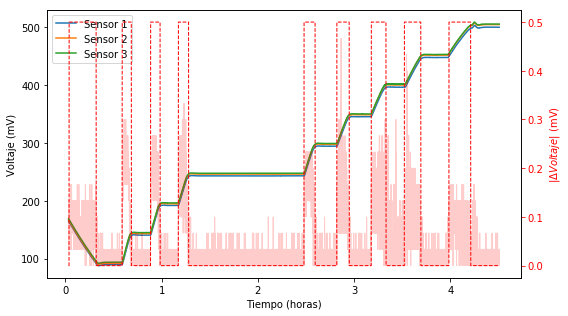

In [5]:
abs_dy, dy = findZeros(ch1, ch2, ch3)
fig, ax1 = plt.subplots(figsize = (8, 4.5))

ax1.plot(ch1[:, 0], ch1[:, 1], label = "Sensor 1")
ax1.plot(ch2[:, 0], ch2[:, 1], label = "Sensor 2")
ax1.plot(ch3[:, 0], ch3[:, 1], label = "Sensor 3")

ax1.set_ylabel("Voltaje (mV)")
ax1.set_xlabel("Tiempo (horas)")

ax2 = ax1.twinx()
ax2.plot(ch1[:, 0], abs_dy, '-', c = 'r', lw = 1,  alpha = 0.2)
ax2.plot(ch1[:, 0], dy, '--', c = 'r', lw = 1)

ax2.set_ylabel("$|\Delta Voltaje|$ (mV)", color='r')
ax2.tick_params('y', colors='r')

ax1.legend()

fig.tight_layout()
fig.savefig("dV-t.png", dpi = 300)
plt.show()

In [6]:
changes = []
for i in range(1, len(dy)):
    diff = dy[i] - dy[i-1]
    if (diff < 0):
        changes.append(i)
    elif (diff > 0):
        changes.append(i)
        
del changes[0]
changes.append(len(dy))
n = len(changes) // 2
changes = np.array(changes).reshape((n, 2))

In [7]:
means = np.zeros((n, 3))
stds = np.zeros((n, 3))
for i in range(n):
    for j in range(3):
        ch = eval("ch%d"%(j + 1))
        fragment = ch[changes[i][0]:changes[i][1], 1]
        means[i, j] = fragment.mean()
        stds[i, j] = fragment.std()

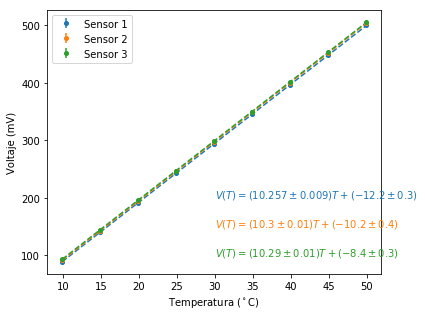

In [8]:
reference = np.array([9.9, 14.9, 19.9, 24.9, 29.9, 34.9, 39.9, 44.9, 49.9])

fig, ax = plt.subplots(figsize = (6, 4.5))

ms = np.zeros((3, 2))
bs = np.zeros((3, 2))

for i in range(3):
    x = reference
    y = means[:, i]
    (m, dm), (b, db) = regression(x, y)
    ms[i] = m, dm
    bs[i] = b, db
    c = ax.errorbar(x, y, yerr = 0.4, fmt = "o", label = "Sensor %d"%(i + 1), ms = 4)[0].get_color()
    
    yy = m * x + b
    ax.plot(x, yy, "--", c = c)
    ax.text(30, 200 - i*50, "$V(T) = (%s \pm %s)T + (%s \pm %s)$"%(m, dm, b, db), color = c)    
    
ax.legend()
ax.set_ylabel("Voltaje (mV)")
ax.set_xlabel("Temperatura ($^\circ$C)")

fig.tight_layout()
fig.savefig("V-T.png", dpi = 300)
plt.show()

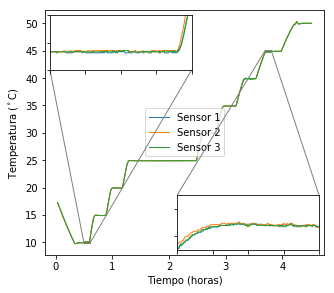

In [9]:
fig, ax = plt.subplots(figsize = (5, 4.5))

axins = zoomed_inset_axes(ax, 25, loc=2) # zoom-factor: 2.5, location: upper-left
plt.yticks(visible=False)
plt.xticks(visible=False)
axins2 = zoomed_inset_axes(ax, 25, loc=4) # zoom-factor: 2.5, location: upper-left
plt.yticks(visible=False)
plt.xticks(visible=False)

for i in range(1, 4):
    ch = eval("ch%d"%i)
    y = getTemperature(ch[:, 1], ms[i-1, 0], bs[i-1, 0])
    ax.plot(ch[:, 0], y, label = "Sensor %d"%i, lw = 1)
    axins.plot(ch[:, 0], y, lw = 1)
    axins2.plot(ch[:, 0], y, lw = 1)
    
ax.legend(loc = 10)
ax.set_xlabel("Tiempo (horas)")
ax.set_ylabel("Temperatura ($^\circ$C)")

axins.set_xlim(0.5, 0.6) # apply the x-limits
axins.set_ylim(9.8, 10.2) # apply the y-limits

axins2.set_xlim(3.7, 3.8) # apply the x-limits
axins2.set_ylim(44.7, 45.1) # apply the y-limits

# axins.set_tick_params(labelbottom=True)
plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
mark_inset(ax, axins2, loc1=1, loc2=2, fc="none", ec="0.5")

plt.savefig("T-t.png", dpi = 300)
plt.show()

In [10]:
data = np.genfromtxt("Temperature.txt", delimiter="\t", skip_header=1)

OSError: Temperature.txt not found.

In [ ]:
plt.plot((1000 * data[:, 1] - bs[0,0]) / ms[0, 0])
plt.plot((1000 * data[:, 2] - bs[1, 0]) / ms[1, 0])
plt.plot((1000 * data[:, 3] - bs[2, 0]) / ms[2, 0])
# plt.plot(data[:, 3])